# Titanic Survivor - Data Science for beginners
### ** Nguyen Dang Minh, PhD **

* [**1. Introduction**](#ch1)

* [**2. Data Preparation**](#ch2)
    * [2.1. Import the data](#ch2.1)
    * [2.2. Fill in missing data](#ch2.2)
    
* [**3. Features Extraction**](#ch3)
    * [3.1. General overview](#ch3.1)
    * [3.2. Analysis on each feature](#ch3.2)
    
* [**4. Building Classification Model**](#ch4)
    * [4.1. Writing the classification function](#ch4.1)
    * [4.2. Prediction with differrent classification model](#4.2)
    
* [**5. Predicting The Test Data**](#ch5)
    

<a id="ch1"></a>

## 1. Introduction

This is the first practice project after I have completed the introduction course [Machine Learning A-Z on Udemy](https://www.udemy.com/machinelearning/) and the first two courses of [Andrew Ng 's deep learning specialization](https://www.coursera.org/specializations/deep-learning).

The goal of the project is to predict whether a passenger onboard the infamous Titanic can survive the accident or not. In order to do that, the computer will be trained using the dataset from Kaggle's ["Titanic: Machine Learning from Disaster"](https://www.kaggle.com/c/titanic) competition. This work focuses strongly on cleaning, preprocessing data (**Section 2**) and features extraction (**Section 3**). Then in **Section 4** I will apply classical classification techniques to gives prediction for the dataset.


<table class='image'>
<img src="https://d.ibtimes.co.uk/en/full/257614/more-1500-people-died-after-titanic-sank-15-april-1912.jpg?w=547&e=a163ac70564918f8e00263e578c939e1" ></img>
<a id='fig1'><center> The Titanic disaster </center></a>
</table>

In [28]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import time

<a id="ch2"></a>

## 2. Data Preparation

<a id="ch2.1"></a>

### 2.1. Import the data

In [29]:
dataset = pd.read_csv('Data/train.csv')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
# Encode sex data so we can better viualize it
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1}).astype(int)

<a id="ch2.2"></a>

### 2.2. Fill in missing data

Let's see which column has missing data

In [31]:
print(dataset.isnull().any())

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool


So we have missing data in `Age`, `Cabin` and `Embark`. Among which, `Cabin` has too many missing. Furthermore, intuitively it should not play any role in one's chance of survival, so we can safely ignore it. This leaves us with `Age` and `Embark`

** Fill in `Embark` **

In [32]:
dataset['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

For this one, we go with majority since more than 80% of passenger boards from the same place (Southampton - `S`). We fill all missing data with this value and encode it.

In [33]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')
dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
dataset['Embarked'].head()

0    0
1    1
2    0
3    0
4    0
Name: Embarked, dtype: int32

** Fill in `Age` **

Age is more tricky since we cannot simply follow majority. Taking the mean is also too simple. To gain a clue, let's look at how all the data are correlated with each other

In [34]:
dataset.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.036847,-0.057527,-0.001652,0.012658,-0.030467
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,0.106811
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.045702
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,0.116569
Age,0.036847,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,0.010171
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,-0.059961
Parch,-0.001652,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,-0.078665
Fare,0.012658,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,0.062142
Embarked,-0.030467,0.106811,0.045702,0.116569,0.010171,-0.059961,-0.078665,0.062142,1.000000


Among all features, `Age` seems to have good correlation with `Pclass` and `SibSp`, so let's see their relationships.

C:\Users\Bubble\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,0.98,'')

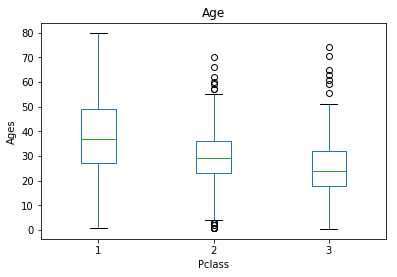

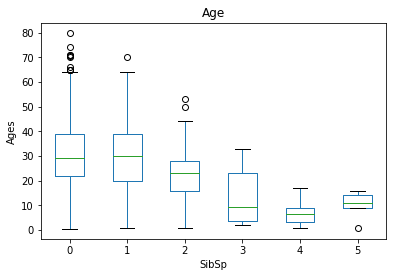

In [35]:
# Extract nan in age
data_age = dataset.dropna(subset=['Age'])
data_no_age = dataset[dataset['Age'].isnull()]

# Age vs Pclass
ax = data_age.boxplot(column='Age', by='Pclass', grid=False)
ax.set_ylabel('Ages')
plt.suptitle("")

# Age vs SibSp
ax = data_age.boxplot(column='Age', by='SibSp', grid=False)
ax.set_ylabel('Ages')
plt.suptitle("")


The data makes sense since it shows that younger passengers tend to travel in a lower class and with more siblings. So let's build a linear regression model to predict `Age` from `Pclass` and `SibSp`

In [36]:
# Extract data for prediction
X_fit_age = data_age[['Pclass', 'SibSp']].loc[:].values
Y_fit_age = data_age['Age'].loc[:].values.reshape(-1,1)

# Building and fitting the model
regressor_fill_age = LinearRegression()
regressor_fill_age.fit(X_fit_age, Y_fit_age)

# Gives prediction
X_pred_age = data_no_age[['Pclass', 'SibSp']].loc[:].values
X_pred_age[:,1][X_pred_age[:,1]>5] = 5
data_no_age['Age'] = regressor_fill_age.predict(X_pred_age)

# Fill in the missing data
data_filled = pd.concat([data_age, data_no_age])
data_filled['Age'] = data_filled['Age'].astype(int)

C:\Users\Bubble\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [37]:
print(data_filled.isnull().any())

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
dtype: bool


Good! Now all missing data except for `Cabin` has been taken care of. Now let's move to feature extraction

<a id="ch3"></a>

## 3. Features Extraction

<a id="ch3.1"></a>

### 3.1. General overview

In [38]:
data_filled.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.224467,0.523008,0.381594,32.204208,0.361392
std,257.353842,0.486592,0.836071,0.477990,13.425747,1.102743,0.806057,49.693429,0.635673
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,0.000000,27.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


** Distribution of each features **

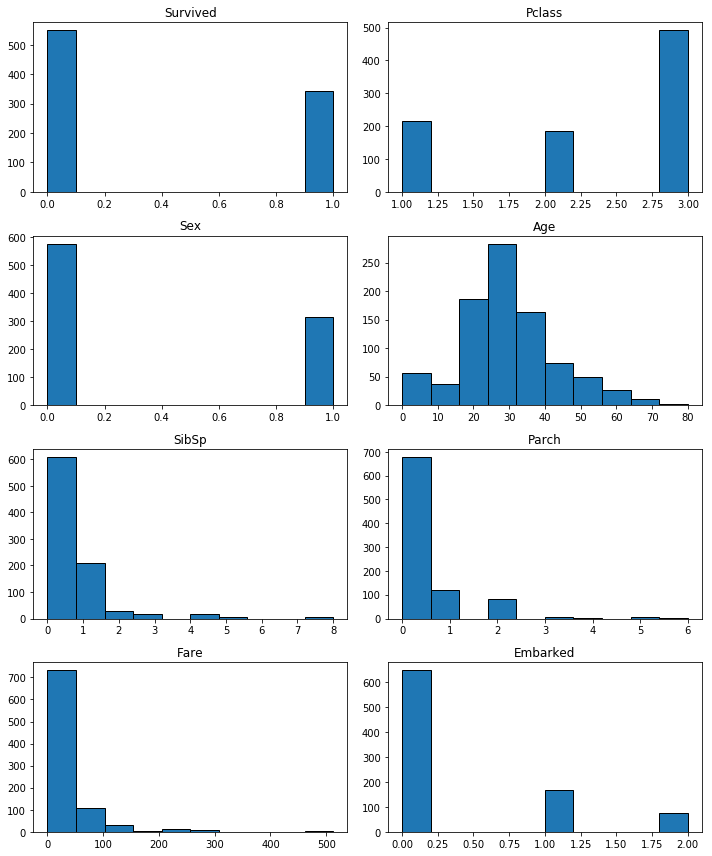

In [39]:
fig = plt.figure(figsize=(10, 12))

ax1 = fig.add_subplot(421)
plt.hist(data_filled['Survived'], edgecolor='black')
plt.title('Survived')

ax2 = fig.add_subplot(422)
plt.hist(data_filled['Pclass'], edgecolor='black')
plt.title('Pclass')

ax2 = fig.add_subplot(423)
plt.hist(data_filled['Sex'], edgecolor='black')
plt.title('Sex')

ax2 = fig.add_subplot(424)
plt.hist(data_filled['Age'], edgecolor='black')
plt.title('Age')

ax2 = fig.add_subplot(425)
plt.hist(data_filled['SibSp'], edgecolor='black')
plt.title('SibSp')

ax2 = fig.add_subplot(426)
plt.hist(data_filled['Parch'], edgecolor='black')
plt.title('Parch')

ax2 = fig.add_subplot(427)
plt.hist(data_filled['Fare'], edgecolor='black')
plt.title('Fare')

ax2 = fig.add_subplot(428)
plt.hist(data_filled['Embarked'], edgecolor='black')
plt.title('Embarked')

plt.tight_layout()

**Some general observation:**
- The training set contains 891 passenger, out of which 38% survived the incident. The total actual number of passenger is 2224 with 32% survivors.
- The majority of passenger stay in third class.
- 65% of passenger are male.
- Passenger's age ranges from 1 to 80 with the majority falls between 20 and 40.
- Most passenger travels alone
- There is a huge variety in fare, which goes up to 512 USD, more than 100 times higher compared to the smallest fare.
- Most passengers boarded the ship from Southampton

** Assumptions to be made before making detailed analysis: **
- `PassengerId` and `Name` should not contribute to one's chance of survival.
- Women and children should have better chance of survival since they are given priority on the saving boats
- Passenger stay in more luxurious class should have better chance of survival since the exit is more accessible
- People travel with families should have better chance of survival.

<a id="ch3.2"></a>

### 3.2. Analysis on each feature

In [40]:
# copy data set to process
data_train = data_filled.copy()
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,0


**`PassengerID`** and ** `Name` ** should make no contribution here and can be ignored. ** `Cabin` ** can also be neglected because of too many missing data.

** `Pclass` **

In [41]:
data_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Passengers in more luxurious class has better chance of survival. We keep this feature


** `Fare` **

`Fare` has strong correlation with `Pclass` (which makes sense). Since there are three categories of classes, we should also put fare into three groups

In [42]:
data_train['FareGrp'] = pd.qcut(data_filled['Fare'], 3)
data_train[['FareGrp', 'Survived']].groupby(['FareGrp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FareGrp,Survived
2,"(26.0, 512.329]",0.559322
1,"(8.662, 26.0]",0.402778
0,"(-0.001, 8.662]",0.198052


In [43]:
filter_fare = lambda x: 0 if x < 8.662 else 1 if (x <26.0 and x >= 8.662) else 2
data_train['Fare'] = data_filled['Fare'].apply(filter_fare)
data_train[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Fare,Survived
2,2,0.552147
1,1,0.377778
0,0,0.203390


Passengers who pay better money stay in better class and have better chance of survival. We keep this feature

** `SibSp` and `Parch` **

In [44]:
data_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [45]:
data_train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


If we neglect the rare cases of passenger travelling with a lot of relatives, it can be seen that having siblings/spouses and parents/child on board the ship gain you a better chance of staying alive compared to being alone. Thus, we can combine these two features into a single one: whether a passengers has relatives or not.

In [46]:
# Has relatives?
data_train['Relatives'] = data_filled['SibSp']+data_filled['Parch']
filter_relatives = lambda x:0 if x<1 else 1
data_train['Relatives'] = data_train['Relatives'].apply(filter_relatives)
data_train[['Relatives', 'Survived']].groupby(['Relatives'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Relatives,Survived
1,1,0.505650
0,0,0.303538


** `Age` **

`Age` should be dividing into three group: children, adult and the old. Here we choose the group boundary based on current criteria.

In [48]:
filter_age = lambda x:0 if x<15 else 1 if (x<55 and x >=15) else 2
data_train['AgeGrp'] = data_filled['Age'].apply(filter_age)
data_train[['AgeGrp', 'Survived']].groupby(['AgeGrp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,AgeGrp,Survived
0,0,0.505618
1,1,0.373684
2,2,0.309524


As expected, children has the most chance of survival and the old has the least. We keep this feature for our model

**`Embarked`**

In [49]:
data_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
1,1,0.553571
2,2,0.389610
0,0,0.339009


`Embark` does play a role in survival and we will keep this feature. However it needs to be encoded.

In [50]:
# Encode the Embarked feature
onehot = OneHotEncoder()
one_hot_matrix = onehot.fit_transform(data_train['Embarked'].loc[:].values.reshape(-1,1)).toarray()
data_train['Embarked S'] = one_hot_matrix[:,0]
data_train['Embarked C'] = one_hot_matrix[:,1]

With this, we have collected all neccessary feature for our models. Let's look at them again

In [52]:
data_train = data_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked S', 'Embarked C', 'AgeGrp', 'Relatives']]
data_train.head()

,Survived,Pclass,Sex,Fare,Embarked S,Embarked C,AgeGrp,Relatives
0,0,3,0,0,1.0,0.0,1,1
1,1,1,1,2,0.0,1.0,1,1
2,1,3,1,0,1.0,0.0,1,0
3,1,1,1,2,1.0,0.0,1,1
4,0,3,0,0,1.0,0.0,1,0


<a id="ch4"></a>

## 4. Building Classification Model

<a id="ch4.1"></a>

### 4.1. Writing the classification function

First let's convert the training data into `numpy_array` and split them to test set and validation set

In [53]:
# Extract training data to array
X_set = data_train.iloc[:,1:].values
Y_set = data_train.loc[:,'Survived'].values

# Splitting training and validation set
seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_set, Y_set, test_size=0.2, random_state=seed)
training_data = [X_train, X_val, Y_train, Y_val]

The goal is to predict whether a passenger can survive the incident or not, so this is a supervised learning, classification problem. Thus we have several choices over which model to use:
- Support Vector Machine
- Decision Tree Classification
- Logistic Regression
- K-Nearest Neighbors

Let's build a common `do_classify` which do use `GridSearchCV` to search for the best hyperparameters for each classifier and output both the training and validation score to us.

In [54]:
def do_classifiy(training_data, classifier, parameters, cv=5):
    '''
    Arguments:
    training_data -- training data set, consist of both train set and validation set
    classifier -- the desire classifier
    parameters -- dictionary of parameters to be tested
    cv -- number fold in cross validation
    
    Returns
    clf_best -- classifier corresponds to the best hyperparameters
    grid_score -- accuracy on training search when doing grid search with k-fold cross validation
    acc_score -- accuracy on the validation set
    
    '''
    X_train, X_val, Y_train, Y_val = training_data
    gs = GridSearchCV(classifier, param_grid=parameters, cv=cv)
    start_time = time.time()
    gs.fit(X_train,Y_train)
    print('Best score: %f, using: %s' %(gs.best_score_, gs.best_params_))
    print('Total run time: %s seconds' %(time.time()-start_time))
    clf_best = gs.best_estimator_
    
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']
    params = gs.cv_results_['params']
    for mean, std, param in zip(means, stds, params):
        print('Test score: %f, std: %f, using %s' %(mean, std, param))
    
    grid_score = gs.best_score_
    acc_score = clf_best.score(X_val, Y_val)
    print('Best train score: %f' %grid_score)
    print('Validation score: %f' %acc_score)
    return clf_best, grid_score, acc_score

<a id="ch4.2"></a>

### 4.2. Prediction with differrent classification model

** SVM **

In [55]:
clf_svm = SVC(kernel='rbf')
params_svm = {'kernel':['rbf', 'sigmoid', 'linear']}
clf_svm, score_svm, acc_svm = do_classifiy(training_data, clf_svm, params_svm)

Best score: 0.807584, using: {'kernel': 'rbf'}
Total run time: 0.759035587310791 seconds
Test score: 0.807584, std: 0.035381, using {'kernel': 'rbf'}
Test score: 0.662921, std: 0.032998, using {'kernel': 'sigmoid'}
Test score: 0.790730, std: 0.025252, using {'kernel': 'linear'}
Best train score: 0.807584
Validation score: 0.787709


** Random Forest **

In [57]:
clf_rf = RandomForestClassifier(n_estimators=10)
params_rf = {'n_estimators': [5, 20, 100]}
clf_rf, score_rf, acc_rf = do_classifiy(training_data, clf_rf, params_rf)

Best score: 0.813202, using: {'n_estimators': 20}
Total run time: 2.631918430328369 seconds
Test score: 0.797753, std: 0.023054, using {'n_estimators': 5}
Test score: 0.813202, std: 0.015576, using {'n_estimators': 20}
Test score: 0.811798, std: 0.025267, using {'n_estimators': 100}
Best train score: 0.813202
Validation score: 0.832402


** K-Nearest Neighbours **

In [60]:
clf_knn = KNeighborsClassifier(n_neighbors=5)
params_knn = {'n_neighbors':[3,10,20]}
clf_knn, score_knn, acc_knn = do_classifiy(training_data, clf_knn, params_knn)

Best score: 0.800562, using: {'n_neighbors': 10}
Total run time: 0.428302526473999 seconds
Test score: 0.778090, std: 0.020114, using {'n_neighbors': 3}
Test score: 0.800562, std: 0.033198, using {'n_neighbors': 10}
Test score: 0.775281, std: 0.012598, using {'n_neighbors': 20}
Best train score: 0.800562
Validation score: 0.798883


** Logistic Regression **

In [61]:
clf_log = LogisticRegression(C=1.0, tol=1e-4)
params_log = {'C':[0.01, 0.1, 1]}
clf_log, score_log, acc_log = do_classifiy(training_data, clf_log, params_log)

Best score: 0.786517, using: {'C': 1}
Total run time: 0.12108492851257324 seconds
Test score: 0.741573, std: 0.013000, using {'C': 0.01}
Test score: 0.772472, std: 0.009826, using {'C': 0.1}
Test score: 0.786517, std: 0.026665, using {'C': 1}
Best train score: 0.786517
Validation score: 0.782123


** Summary of all models **

In [62]:
models = pd.DataFrame({'Model': ['Support Vector Machine', 'Random Forest',
                                 'K-Nearest Neighbours', 'Logistic Regression'],
    'Training score': [score_svm, score_rf, score_knn, score_log],
    'Validation score': [acc_svm, acc_rf, acc_knn, acc_log]})
columns_title = ['Model', 'Training score', 'Validation score']
models = models.reindex(columns=columns_title)
models.sort_values(by='Validation score', ascending=False)

,Model,Training score,Validation score
1,Random Forest,0.813202,0.832402
2,K-Nearest Neighbours,0.800562,0.798883
0,Support Vector Machine,0.807584,0.787709
3,Logistic Regression,0.786517,0.782123


Based on this result, we will use the **Random Forest Classifier** for our problem with the accuracy expected to be **83%**

<a id="ch5"></a>

## 5. Predicting The Test Data

The first step is to import the test set and preprocess it just like we did with the training set

In [63]:
# Import
testset = pd.read_csv('Data/test.csv')

# Emcode sex
testset['Sex'] = testset['Sex'].map({'male':0, 'female':1}).astype(int)

# Fill in missing and encode Embarked
testset['Embarked'] = testset['Embarked'].fillna('S')
testset['Embarked'] = testset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
onehot = OneHotEncoder()
one_hot_matrix = onehot.fit_transform(testset['Embarked'].loc[:].values.reshape(-1,1)).toarray()
testset['Embarked S'] = one_hot_matrix[:,0]
testset['Embarked C'] = one_hot_matrix[:,1]

# Fill in missing age
X_pred_age = testset[['Pclass', 'SibSp']].loc[:].values
X_pred_age[:,1][X_pred_age[:,1]>5] = 5
age_pred = regressor_fill_age.predict(X_pred_age)
for i in range(len(testset['Age'])):
    if pd.isnull(testset.loc[i,'Age']):
        testset.loc[i,'Age'] = int(age_pred[i])

# Age group
testset['AgeGrp'] = testset['Age'].apply(filter_age)
        
# Encode the fare
testset['Fare'] = testset['Fare'].apply(filter_fare)

# Encode Relatives
testset['Relatives'] = testset['SibSp']+testset['Parch']
testset['Relatives'] = testset['Relatives'].apply(filter_relatives)

# Extract data for prediction
for_pred = testset[['Pclass', 'Sex', 'Fare', 'Embarked S', 'Embarked C', 'AgeGrp', 'Relatives']]
X = for_pred.loc[:,:].values

We then apply Random Forest Classification to the processed data and publish the result into a .csv file

In [64]:
# Make predict
Y_pred = clf_rf.predict(X)

# Write output to a file
ID = testset['PassengerId']
filename = 'result.csv'
myfile = open(filename,'w')
titleRow = 'PassengerID,Survived\n'
myfile.write(titleRow)
for i in range(len(Y_pred)):
    row = str(ID[i]) + ',' + str(Y_pred[i]) + '\n'
    myfile.write(row)
myfile.close()